## 컴퓨터언어학 과제 3

### Constructing a sequence-to-sequence (encoder-decoder) model for machine translation

### English --> Finnish translation
  
   
  

### encoder/decoder layer수, hidden dimension, teacher forcing ratio 등을 바꿔가며 11번의 trial을 해보았는데, 성능이 그렇게 좋지 않아서 선택한 언어(핀란드어)의 영향인지 알아보기 위해 다른 언어(한국어)에도 동일한 모델을 적용해보았습니다(Trial 6,7). 따라서 Data downloading과 Data processing에 한국어 데이터를 처리하는 부분이 조금 혼재되어 있는데, 한국어 처리 셀들은 맨 위에 ############ IGNORE로 표시해두었습니다. 이 부분들은 무시하셔도 괜찮습니다.
  
### BLEU Score는 TRIAL 9의 성능이 가장 좋았지만, Test loss와 Inference 결과는 TRIAL 11이 가장 좋았습니다. 이 둘은 모두 encoder/decoder layer 수가 1로 동일했으나 teacher forcing ratio를 각각 0.7, 0.5로 달리 학습시켰습니다.

### 0. Set environments

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install torchtext==0.6.0

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

from torchtext.data import Field, BucketIterator, TabularDataset
from torchtext.data.metrics import bleu_score
import pandas as pd
import re

import zipfile

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
SEED = 2319

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Data downloading

In [3]:
# English-Finnish data from http://www.manythings.org/anki/
# consisting of 70641 sentences
!wget http://www.manythings.org/anki/fin-eng.zip

--2023-05-26 12:30:43--  http://www.manythings.org/anki/fin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2437292 (2.3M) [application/zip]
Saving to: ‘fin-eng.zip’

fin-eng.zip         100%[===================>]   2.32M  8.65MB/s    in 0.3s    

2023-05-26 12:30:43 (8.65 MB/s) - ‘fin-eng.zip’ saved [2437292/2437292]



In [ ]:
############ IGNORE
# English-Korean data from http://www.manythings.org/anki/
# consisting of 5794 sentences
!wget http://www.manythings.org/anki/kor-eng.zip

--2023-05-26 11:24:48--  http://www.manythings.org/anki/kor-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226548 (221K) [application/zip]
Saving to: ‘kor-eng.zip’

kor-eng.zip         100%[===================>] 221.24K   288KB/s    in 0.8s    

2023-05-26 11:24:50 (288 KB/s) - ‘kor-eng.zip’ saved [226548/226548]



In [4]:
# Unzip the fin-eng file
with zipfile.ZipFile('./fin-eng.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
############ IGNORE
# Unzip the fra-eng file
with zipfile.ZipFile('./kor-eng.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

### 2. Data Preprocessing and Data Iterators

The following codes are based on the following github page and lecture notes.
https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb

In [5]:
# Load English and Finnish spacy pipelines

!python3 -m spacy download fi_core_news_sm

spacy_eng = spacy.load('en_core_web_sm')
spacy_fin = spacy.load('fi_core_news_sm') # finnish

2023-05-26 12:31:02.399123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 22.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fi_core_news_sm')


In [ ]:
############ IGNORE
# Load English and Korean spacy pipelines

!python3 -m spacy download ko_core_news_sm

spacy_eng = spacy.load('en_core_web_sm')
spacy_kor = spacy.load('ko_core_news_sm') # korean

2023-05-26 11:26:12.824874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 14.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ko_core_news_sm')


In [6]:
# Define tokenizers for english and finnish texts

def tokenize_eng(text):
    tokens = []
    for token in spacy_eng.tokenizer(text):
        tokens.append(token.text)
    return tokens

def tokenize_fin(text):
    tokens = []
    for token in spacy_fin.tokenizer(text):
        tokens.append(token.text)
    return tokens


############ IGNORE
def tokenize_kor(text):
    tokens = []
    for token in spacy_kor.tokenizer(text):
        tokens.append(token.text)
    return tokens

In [7]:
# Define Field

SRC = Field(tokenize = tokenize_eng, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_fin, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
############ IGNORE
# Redefine Field for KOREAN

TRG = Field(tokenize = tokenize_kor, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [8]:
# Function to read text file and turn it into a dataframe

def readFile(lang1, lang2):  # lang1(source), lang2(target)
    
    # Read the file and split into lines
    lines = open('%s.txt' % (lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and make a dataframe
    df = pd.DataFrame(columns = ['src', 'trg'])
    for l in lines:
      tabs = l.split('\t')
      df.loc[len(df)] = {'src' : tabs[0], 'trg' : tabs[1]}

    return df

In [9]:
eng_fin = readFile('eng', 'fin')
eng_fin.to_csv('./eng_fin.csv', index=False)

In [ ]:
############ IGNORE
eng_kor = readFile('eng', 'kor')
eng_kor.to_csv('./eng_kor.csv', index=False)

In [ ]:
eng_fin

,src,trg
0,Go.,Mene.
1,Hi.,Moro!
2,Hi.,Terve.
3,Run!,Juokse!
4,Run!,Juoskaa!
...,...,...
70636,"At a moment when our economy is growing, our b...","Tällä hetkellä kun taloutemme on kasvussa, yri..."
70637,The driver of an oncoming car flashed his ligh...,Vastaanajavan auton kuski väläytti valojaan va...
70638,If someone who doesn't know your background sa...,"Jos joku, joka ei tunne taustaasi, sanoo että ..."
70639,It may be impossible to get a completely error...,Saattaa olla mahdotonta saada täysin virheetön...


In [ ]:
############ IGNORE
eng_kor

,src,trg
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?
...,...,...
5789,I started a new blog. I'll do my best not to b...,난 블로그를 시작했어. 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지 ...
5790,I think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
5791,And the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다. 임금, 소득, 집값, 퇴직..."
5792,If someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...


In [10]:
# Load data

data = TabularDataset(
    path='./eng_fin.csv', format='csv',
    fields=[('src', SRC), ('trg', TRG)], skip_header=True)

In [ ]:
############ IGNORE
# Reload Korean data

data = TabularDataset(
    path='./eng_kor.csv', format='csv',
    fields=[('src', SRC), ('trg', TRG)], skip_header=True)

In [11]:
print(vars(data[0]))

{'src': ['go', '.'], 'trg': ['mene', '.']}


In [ ]:
############ IGNORE
print(vars(data[0]))

{'src': ['go', '.'], 'trg': ['가', '.']}


In [12]:
# Split the dataset into training and test sets(9:1)
train_data, test_data = data.split(split_ratio=0.9, random_state = random.seed(SEED))

# Further, split the train_data into training and valid sets(9:1)
train_data, valid_data = train_data.split(split_ratio=0.9, random_state = random.seed(SEED))

In [13]:
print(f"Number of training data: {len(train_data)}")
print(f"Number of validation data: {len(valid_data)}")
print(f"Number of testing data: {len(test_data)}")

Number of training data: 57219
Number of validation data: 6358
Number of testing data: 7064


In [ ]:
############ IGNORE
# KOREAN data
print(f"Number of training data: {len(train_data)}")
print(f"Number of validation data: {len(valid_data)}")
print(f"Number of testing data: {len(test_data)}")

Number of training data: 4694
Number of validation data: 521
Number of testing data: 579


In [14]:
# Build vocab

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [15]:
print(f"Number of unique tokens in SRC(English) vocabulary: {len(SRC.vocab)}")
print(f"Number of unique tokens in TRG(Finnish) vocabulary: {len(TRG.vocab)}")

Number of unique tokens in SRC(English) vocabulary: 6232
Number of unique tokens in TRG(Finnish) vocabulary: 14032


In [ ]:
############ IGNORE
print(f"Number of unique tokens in SRC(English) vocabulary: {len(SRC.vocab)}")
print(f"Number of unique tokens in TRG(Korean) vocabulary: {len(TRG.vocab)}")

Number of unique tokens in SRC(English) vocabulary: 1529
Number of unique tokens in TRG(Korean) vocabulary: 2122


In [16]:
# Define Data Iterators

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     shuffle = True,
     sort_key = lambda x : len(x.src),  # source sentence(english sentence)의 길이에 따라 정렬
     device = device)

### 3. Encoder and Decoder

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, enc_hid_dim, n_layers, dropout=dropout, bidirectional = True)
        
        # bidirectional이므로 양방향으로 출력되는 두 최종 hidden state를 concat할 것
        # Encoder의 final hidden state(context vector)가 Decoder의 initial hidden state로
        # 바로 사용될 수 있도록 하기위해 self.fc통해 dimension을 맞춰줌
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        # 현재 outputs, hidden tensor size
        # outputs = [src len, batch size, enc_hid_dim * 2]
        # hidden = [n_layers*2, batch size, enc_hid_dim]
        
        # hidden [-2, :, : ]는 마지막 layer forward GRU의 hidden state
        # hidden [-1, :, : ]는 마지막 layer backward GRU의 hidden state
        # --> 두 정보를 모두 담은 하나의 hidden을 만들 것
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = self.fc(hidden)
        hidden = torch.tanh(hidden)
        # now, hidden = [batch size, dec_hid_dim]
        
        return outputs, hidden

        # 따라서,
        # outputs = [src len, batch size, enc_hid_dim * 2]
        # hidden = [batch size, dec_hid_dim]

In [18]:
# Additive Attention

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        # encoder outputs와 decoder hidden state를 concat하고 통과시킬 linear layer
        # encoder outputs와 decoder hidden state 사이의 similarity를 나타내게 됨 (이후 tanh layer 통과해야함)
        self.fc1 = nn.Linear(enc_hid_dim * 2 + dec_hid_dim, dec_hid_dim)

        # Attention은 input(source) sentence만큼의, 또는 그 이상의 크기를 가져야함
        # 출력값이 각 source sentence에 대한 attention weight를 나타내므로 그에 맞게 크기 조정할 때 쓰이는 layer
        # dec_hid_dim 만큼의 dimension을 가지는 벡터를 1 dimension 값으로 대응 --> 이 값은 source sentence 각 토큰에 대한 attention weight
        self.fc2 = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        # input tensor들의 사이즈
        # encoder_outputs = [src len, batch size, enc_hid_dim * 2]
        # hidden = [batch size, dec_hid_dim]

        src_len = encoder_outputs.shape[0]
        batch_size = encoder_outputs.shape[1]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src len, enc_hid_dim * 2]
        
        # hidden의 사이즈를 encoder_outputs 사이즈와 동일하게 맞춰줌
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # now, hidden = [batch size, src len, dec_hid_dim]
        
        # Additive attention
        attention = torch.tanh(self.fc1(torch.cat((hidden, encoder_outputs), dim = 2))) 
        # attention = [batch size, src len, dec_hid_dim]

        attention = self.fc2(attention)
        # attention= [batch size, src len, 1]
        attention = attention.squeeze(2)
        # attention= [batch size, src len]
        attention = F.softmax(attention, dim=1)
        
        return attention
        # attention= [batch size, src len]

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention, n_layers):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
    def forward(self, input, hidden, encoder_outputs):
        # input 처리
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        # embedded = [1, batch size, emb dim]
        
        # attention 계산
        # attention layer에 들어가는 hidden(decoder hidden state)의 shape이 [batch size, dec_hid_dim]이어야 함
        # Decoder의 hidden state가 [n_layers, batch size, dec_hid_dim] size를 가지므로
        # hidden[-1]해서 [batch size, dec_hid_dim]의 사이즈를 가지는, 마지막 layer의 hidden state만 attention 계산에 사용할 것

        # 그런데 첫 번째 timestep에서는 encoder의 hidden state를 input으로 받음
        # encoder hidden state의 shape은 [batch size, dec_hid_dim]임
        # self.gru에 넣어주기 위해 [n_layers, batch size, dec_hid_dim] 사이즈로 변경해줌
        if len(hidden.shape)==2:   # encoder hidden state가 들어왔을 때, 따로 처리해주어야 하는 부분
          hidden = hidden.unsqueeze(0).repeat(self.n_layers, 1, 1)  # [n_layers, batch size, dec_hid_dim]로 shape 변경

        last_hidden = hidden[-1]  # 디코더의 마지막 layer hidden state

        a = self.attention(last_hidden, encoder_outputs)
        a = a.unsqueeze(1)
        # a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        # weighted sum of the encoder hidden states
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, enc hid dim * 2]
        
        # embedded input과 concat하기 위해 dimension 조정
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, enc hid dim * 2]
        
        # GRU에 embedded input word, weighted source vector, previous decoder hidden state 들어감
        # embedded input word와 weighted source vector는 concat해서 넣어줌
        gru_input = torch.cat((embedded, weighted), dim = 2)
        #gru_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.gru(gru_input, hidden)
        # output = [seq len(=1), batch size, dec hid dim]
        # hidden = [n_layers, batch size, dec hid dim]
        assert (output[-1] == hidden[-1]).all()
        
        embedded = embedded.squeeze(0)
        # embedded = [batch size, emb dim]
        output = output.squeeze(0)
        # output = [batch size, dec hid dim]
        weighted = weighted.squeeze(0)
        # weighted = [batch size, enc hid dim * 2]
        
        # 다음 단어 예측
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        # prediction = [batch size, output dim]
        
        return prediction, hidden, a.squeeze(1)
        # prediction = [batch size, output dim]
        # hidden = [n_layers, batch size, dec hid dim]
        # a.squeeze(1) = [batch size, src_len]

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        
        batch_size = src.shape[1]

        # 정답 문장의 길이를 알고 있으므로, 정답 문장의 길이만큼만 prediction을 수행할 것
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # Target prediction을 저장할 텐서(정답의 길이에 맞추어 initialize해둠)
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src)
                
        # First input to the decoder : <sos>
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            out, hidden, __ = self.decoder(input, hidden, encoder_outputs)
            
            # Timestep t의 prediction을 기록
            outputs[t] = out
            
            # teacher forcing 적용할지 말지 결정
            teacher_force = random.random() < teacher_forcing_ratio
            
            # 가장 확률이 높은 토큰
            top = out.argmax(1)
            
            # teacher forcing 사용한다면 정답 token을 다음 인풋으로 사용
            # 그렇지 않으면 방금 예측한 token을 다음 인풋으로 사용
            if teacher_force:
              input = trg[t]
            else:
              input = top

        return outputs
        # outputs = [trg_len, batch_size, trg_vocab_size]

### 4. Preparing Training and Evaluating

In [45]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ENC_NUM_OF_LAYERS = 1
DEC_NUM_OF_LAYERS = 1

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_NUM_OF_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn, DEC_NUM_OF_LAYERS)

model = Seq2Seq(enc, dec, device).to(device)

In [46]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6232, 256)
    (gru): GRU(256, 512, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (fc1): Linear(in_features=1536, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(14032, 256)
    (gru): GRU(1280, 512, dropout=0.5)
    (fc_out): Linear(in_features=1792, out_features=14032, bias=True)
  )
)

In [47]:
# Define Optimizer and Criterion

optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        # trg = [trg len, batch size]
        
        optimizer.zero_grad()
        
        # Decoder에서 각 timestep마다 계산한 target vocabs에 대한 predictions를 출력
        output = model(src, trg)
        # output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        # trg = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 5. Training

In [ ]:
# Trial1. encoder 3 layers, decoder 6 layers, 20 epochs
# --> epoch가 10을 넘어가면 valid loss가 증가하므로 뒤에서는 epoch를 10으로 사용
# --> layer 3개, 6개는 데이터에 비해 너무 복잡한가 싶었음

N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 3m 29s
	Train Loss: 4.686
	 Val. Loss: 3.746
Epoch: 02 | Time: 3m 23s
	Train Loss: 2.915
	 Val. Loss: 2.697
Epoch: 03 | Time: 3m 26s
	Train Loss: 2.013
	 Val. Loss: 2.537
Epoch: 04 | Time: 3m 25s
	Train Loss: 1.599
	 Val. Loss: 2.565
Epoch: 05 | Time: 3m 34s
	Train Loss: 1.398
	 Val. Loss: 2.568
Epoch: 06 | Time: 3m 29s
	Train Loss: 1.279
	 Val. Loss: 2.737
Epoch: 07 | Time: 3m 29s
	Train Loss: 1.177
	 Val. Loss: 2.681
Epoch: 08 | Time: 3m 32s
	Train Loss: 1.112
	 Val. Loss: 2.694
Epoch: 09 | Time: 3m 31s
	Train Loss: 1.060
	 Val. Loss: 2.770
Epoch: 10 | Time: 3m 30s
	Train Loss: 1.036
	 Val. Loss: 2.810
Epoch: 11 | Time: 3m 27s
	Train Loss: 0.991
	 Val. Loss: 2.824
Epoch: 12 | Time: 3m 35s
	Train Loss: 0.974
	 Val. Loss: 2.903
Epoch: 13 | Time: 3m 30s
	Train Loss: 0.960
	 Val. Loss: 2.951
Epoch: 14 | Time: 3m 29s
	Train Loss: 0.949
	 Val. Loss: 3.072
Epoch: 15 | Time: 3m 27s
	Train Loss: 0.925
	 Val. Loss: 3.038
Epoch: 16 | Time: 3m 26s
	Train Loss: 0.918
	 Val. Loss

In [ ]:
# Trial2. layer 수를 줄여봄
# encoder 2 layers, decoder 4 layers, 10 epochs
# Trial1과 큰 차이는 없는 것 같음

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 3m 6s
	Train Loss: 4.726
	 Val. Loss: 3.629
Epoch: 02 | Time: 2m 55s
	Train Loss: 2.891
	 Val. Loss: 2.642
Epoch: 03 | Time: 3m 14s
	Train Loss: 1.962
	 Val. Loss: 2.532
Epoch: 04 | Time: 3m 12s
	Train Loss: 1.508
	 Val. Loss: 2.552
Epoch: 05 | Time: 3m 11s
	Train Loss: 1.303
	 Val. Loss: 2.469
Epoch: 06 | Time: 3m 7s
	Train Loss: 1.174
	 Val. Loss: 2.518
Epoch: 07 | Time: 3m 12s
	Train Loss: 1.065
	 Val. Loss: 2.545
Epoch: 08 | Time: 3m 8s
	Train Loss: 0.989
	 Val. Loss: 2.610
Epoch: 09 | Time: 3m 6s
	Train Loss: 0.922
	 Val. Loss: 2.660
Epoch: 10 | Time: 3m 9s
	Train Loss: 0.876
	 Val. Loss: 2.699


In [ ]:
# Trial3. encoder 3 layers, decoder 3 layers, 10 epochs
# encoder, decoder layer수가 같으면 더 나을까 해서 해봤는데 큰 차이 없는 것 같긴함

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 3m 22s
	Train Loss: 4.611
	 Val. Loss: 3.487
Epoch: 02 | Time: 3m 16s
	Train Loss: 2.821
	 Val. Loss: 2.759
Epoch: 03 | Time: 3m 13s
	Train Loss: 1.966
	 Val. Loss: 2.648
Epoch: 04 | Time: 3m 13s
	Train Loss: 1.545
	 Val. Loss: 2.582
Epoch: 05 | Time: 3m 12s
	Train Loss: 1.369
	 Val. Loss: 2.593
Epoch: 06 | Time: 3m 6s
	Train Loss: 1.258
	 Val. Loss: 2.663
Epoch: 07 | Time: 3m 16s
	Train Loss: 1.173
	 Val. Loss: 2.690
Epoch: 08 | Time: 3m 17s
	Train Loss: 1.112
	 Val. Loss: 2.752
Epoch: 09 | Time: 3m 23s
	Train Loss: 1.066
	 Val. Loss: 2.801
Epoch: 10 | Time: 3m 9s
	Train Loss: 1.035
	 Val. Loss: 2.842


In [ ]:
# Trial4. encoder 3 layers, decoder 3 layers, 10 epochs
# encoder/decoder hidden dimension을 512-->1024
# --> 성능이 오히려 더 안좋아짐, hidden dimension은 512로 유지하기

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 7m 36s
	Train Loss: 4.494
	 Val. Loss: 3.744
Epoch: 02 | Time: 7m 39s
	Train Loss: 2.771
	 Val. Loss: 2.824
Epoch: 03 | Time: 7m 32s
	Train Loss: 2.016
	 Val. Loss: 2.753
Epoch: 04 | Time: 7m 28s
	Train Loss: 1.649
	 Val. Loss: 2.776
Epoch: 05 | Time: 7m 32s
	Train Loss: 1.488
	 Val. Loss: 2.804
Epoch: 06 | Time: 7m 37s
	Train Loss: 1.424
	 Val. Loss: 2.870
Epoch: 07 | Time: 7m 32s
	Train Loss: 1.381
	 Val. Loss: 3.041
Epoch: 08 | Time: 7m 35s
	Train Loss: 1.420
	 Val. Loss: 3.136
Epoch: 09 | Time: 7m 32s
	Train Loss: 1.491
	 Val. Loss: 3.288
Epoch: 10 | Time: 7m 32s
	Train Loss: 1.537
	 Val. Loss: 3.393


In [ ]:
# Trial5. encoder 3 layers, decoder 3 layers, 10 epochs, encoder/decoder hidden dimension 1024-->512 again (same as Trial3)
# But teacher forcing ratio is 0.3

####### teacher forcing ratio 바꾸기 위해 train function 재정의
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg, 0.3) # teacher forcing ratio = 0.3
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)
#######

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 3m 16s
	Train Loss: 4.819
	 Val. Loss: 3.556
Epoch: 02 | Time: 3m 16s
	Train Loss: 3.066
	 Val. Loss: 2.798
Epoch: 03 | Time: 3m 20s
	Train Loss: 2.159
	 Val. Loss: 2.646
Epoch: 04 | Time: 3m 17s
	Train Loss: 1.732
	 Val. Loss: 2.477
Epoch: 05 | Time: 3m 13s
	Train Loss: 1.514
	 Val. Loss: 2.503
Epoch: 06 | Time: 3m 12s
	Train Loss: 1.393
	 Val. Loss: 2.487
Epoch: 07 | Time: 3m 13s
	Train Loss: 1.303
	 Val. Loss: 2.538
Epoch: 08 | Time: 3m 13s
	Train Loss: 1.235
	 Val. Loss: 2.593
Epoch: 09 | Time: 3m 11s
	Train Loss: 1.186
	 Val. Loss: 2.643
Epoch: 10 | Time: 3m 13s
	Train Loss: 1.155
	 Val. Loss: 2.687


In [ ]:
# 성능이 자꾸 안나와서 혹시 핀란드어가 너무 어려워서 그런가하고 다른 언어 데이터(한국어)를 사용해봄
# Trial6. KOREAN DATA
# encoder 3 layers, decoder 3 layers, 10 epochs, encoder/decoder hidden dimension 512
# teacher forcing ratio = 0.5

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.745
	 Val. Loss: 3.631
Epoch: 02 | Time: 0m 17s
	Train Loss: 3.276
	 Val. Loss: 3.345
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.371
	 Val. Loss: 3.173
Epoch: 04 | Time: 0m 16s
	Train Loss: 1.744
	 Val. Loss: 3.119
Epoch: 05 | Time: 0m 16s
	Train Loss: 1.404
	 Val. Loss: 3.081
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.185
	 Val. Loss: 3.152
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.009
	 Val. Loss: 3.183
Epoch: 08 | Time: 0m 16s
	Train Loss: 0.899
	 Val. Loss: 3.226
Epoch: 09 | Time: 0m 16s
	Train Loss: 0.778
	 Val. Loss: 3.301
Epoch: 10 | Time: 0m 16s
	Train Loss: 0.680
	 Val. Loss: 3.349


In [ ]:
# Trial7. KOREAN DATA
# 데이터가 적어서 레이어 수를 줄이고 에포크를 늘려봄
# encoder 1 layers, decoder 1 layers, 30 epochs, encoder/decoder hidden dimension 512
# teacher forcing ratio = 0.5

N_EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 5s
	Train Loss: 5.006
	 Val. Loss: 3.984
Epoch: 02 | Time: 0m 5s
	Train Loss: 4.201
	 Val. Loss: 3.876
Epoch: 03 | Time: 0m 5s
	Train Loss: 3.962
	 Val. Loss: 3.624
Epoch: 04 | Time: 0m 5s
	Train Loss: 3.662
	 Val. Loss: 3.522
Epoch: 05 | Time: 0m 5s
	Train Loss: 3.410
	 Val. Loss: 3.440
Epoch: 06 | Time: 0m 5s
	Train Loss: 3.226
	 Val. Loss: 3.364
Epoch: 07 | Time: 0m 5s
	Train Loss: 3.032
	 Val. Loss: 3.384
Epoch: 08 | Time: 0m 5s
	Train Loss: 2.789
	 Val. Loss: 3.277
Epoch: 09 | Time: 0m 5s
	Train Loss: 2.545
	 Val. Loss: 3.400
Epoch: 10 | Time: 0m 5s
	Train Loss: 2.339
	 Val. Loss: 3.336
Epoch: 11 | Time: 0m 5s
	Train Loss: 2.073
	 Val. Loss: 3.314
Epoch: 12 | Time: 0m 5s
	Train Loss: 1.792
	 Val. Loss: 3.328
Epoch: 13 | Time: 0m 5s
	Train Loss: 1.528
	 Val. Loss: 3.327
Epoch: 14 | Time: 0m 5s
	Train Loss: 1.273
	 Val. Loss: 3.355
Epoch: 15 | Time: 0m 5s
	Train Loss: 1.035
	 Val. Loss: 3.516
Epoch: 16 | Time: 0m 5s
	Train Loss: 0.879
	 Val. Loss: 3.536
Epoch: 1

In [26]:
# 언어의 문제가 아니었던 것 같음..
# Trial8. RETURN TO FINNISH...
# encoder 3 layers, decoder 3 layers, 10 epochs, encoder/decoder hidden dimension 512 again
# But teacher forcing ratio is 0.7
# --> teacher forcing ratio를 늘리니까 성능이 더 안좋아짐

####### teacher forcing ratio 바꾸기 위해 train function 재정의
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg, 0.7) # teacher forcing ratio = 0.7
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)
#######

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 3m 10s
	Train Loss: 4.483
	 Val. Loss: 3.605
Epoch: 02 | Time: 3m 7s
	Train Loss: 2.657
	 Val. Loss: 2.854
Epoch: 03 | Time: 2m 55s
	Train Loss: 1.788
	 Val. Loss: 2.803
Epoch: 04 | Time: 2m 57s
	Train Loss: 1.384
	 Val. Loss: 2.715
Epoch: 05 | Time: 3m 2s
	Train Loss: 1.199
	 Val. Loss: 2.779
Epoch: 06 | Time: 3m 0s
	Train Loss: 1.089
	 Val. Loss: 2.804
Epoch: 07 | Time: 3m 6s
	Train Loss: 1.006
	 Val. Loss: 2.905
Epoch: 08 | Time: 3m 0s
	Train Loss: 0.946
	 Val. Loss: 2.941
Epoch: 09 | Time: 2m 59s
	Train Loss: 0.905
	 Val. Loss: 3.008
Epoch: 10 | Time: 3m 0s
	Train Loss: 0.866
	 Val. Loss: 3.125


In [ ]:
# Trial9. Trial8에서 layer수를 줄이면 어떨까하고 시도해봄
# encoder 1 layer, decoder 1 layer, 10 epochs, encoder/decoder hidden dimension 512 again
# teacher forcing ratio 0.7

####### teacher forcing ratio 바꾸기 위해 train function 재정의
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg, 0.7) # teacher forcing ratio = 0.7
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)
#######

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 2m 39s
	Train Loss: 4.604
	 Val. Loss: 3.766
Epoch: 02 | Time: 2m 39s
	Train Loss: 2.734
	 Val. Loss: 2.855
Epoch: 03 | Time: 2m 40s
	Train Loss: 1.738
	 Val. Loss: 2.677
Epoch: 04 | Time: 2m 40s
	Train Loss: 1.220
	 Val. Loss: 2.630
Epoch: 05 | Time: 2m 38s
	Train Loss: 0.969
	 Val. Loss: 2.610
Epoch: 06 | Time: 2m 40s
	Train Loss: 0.825
	 Val. Loss: 2.716
Epoch: 07 | Time: 2m 43s
	Train Loss: 0.720
	 Val. Loss: 2.769
Epoch: 08 | Time: 2m 39s
	Train Loss: 0.640
	 Val. Loss: 2.837
Epoch: 09 | Time: 2m 39s
	Train Loss: 0.581
	 Val. Loss: 2.910
Epoch: 10 | Time: 2m 40s
	Train Loss: 0.541
	 Val. Loss: 3.001


In [38]:
# Trial10.
# teacher forcing을 0.3으로 줄인 Trial5의 성능이 가장 좋았던 거 같고
# Trial 8에서 teacher forcing을 늘리니 성능이 더 줄어듦 --> teacher forcing을 0.2로 더 줄여서 돌려봄
# Trial 8에서 Trial 9로 넘어가며, 동일한 조건에서 layer 수만 줄였는데 성능이 향상됨
# layer 수를 (계속 주로 사용하던) 3에서 2로 줄여서 돌려봄

# encoder 2 layers, decoder 2 layers, 10 epochs, encoder/decoder hidden dimension 512 again
# But teacher forcing ratio is 0.2

####### teacher forcing ratio 바꾸기 위해 train function 재정의
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg, 0.2) # teacher forcing ratio = 0.2
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)
#######

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 2m 53s
	Train Loss: 4.829
	 Val. Loss: 3.772
Epoch: 02 | Time: 2m 51s
	Train Loss: 3.062
	 Val. Loss: 2.666
Epoch: 03 | Time: 2m 50s
	Train Loss: 2.135
	 Val. Loss: 2.369
Epoch: 04 | Time: 2m 51s
	Train Loss: 1.686
	 Val. Loss: 2.361
Epoch: 05 | Time: 2m 50s
	Train Loss: 1.463
	 Val. Loss: 2.379
Epoch: 06 | Time: 2m 58s
	Train Loss: 1.335
	 Val. Loss: 2.362
Epoch: 07 | Time: 2m 57s
	Train Loss: 1.220
	 Val. Loss: 2.411
Epoch: 08 | Time: 2m 43s
	Train Loss: 1.153
	 Val. Loss: 2.493
Epoch: 09 | Time: 2m 55s
	Train Loss: 1.091
	 Val. Loss: 2.477
Epoch: 10 | Time: 2m 41s
	Train Loss: 1.036
	 Val. Loss: 2.584


In [48]:
# Trial 11.
# Loss는 Trial 10이 가장 낮지만 BLEU score는 Trial10보다 Trial9가 더 높음(Trial 10의 inference 결과도 좋지않음)

# --> 이 둘을 절충한 모델을 한번 돌려봄
# teacher forcing 0.5
# encoder 1 layer, decoder 1 layer

# 10 epochs, encoder/decoder hidden dimension 512 again
# gradient clipping도 적용해봄

####### clipping 적용 위해 train function 재정의
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)
#######

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'attn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 2m 36s
	Train Loss: 4.554
	 Val. Loss: 3.591
Epoch: 02 | Time: 2m 38s
	Train Loss: 2.775
	 Val. Loss: 2.641
Epoch: 03 | Time: 2m 36s
	Train Loss: 1.832
	 Val. Loss: 2.414
Epoch: 04 | Time: 2m 36s
	Train Loss: 1.343
	 Val. Loss: 2.394
Epoch: 05 | Time: 2m 25s
	Train Loss: 1.093
	 Val. Loss: 2.421
Epoch: 06 | Time: 2m 22s
	Train Loss: 0.944
	 Val. Loss: 2.463
Epoch: 07 | Time: 2m 23s
	Train Loss: 0.834
	 Val. Loss: 2.531
Epoch: 08 | Time: 2m 25s
	Train Loss: 0.757
	 Val. Loss: 2.620
Epoch: 09 | Time: 2m 36s
	Train Loss: 0.699
	 Val. Loss: 2.663
Epoch: 10 | Time: 2m 32s
	Train Loss: 0.656
	 Val. Loss: 2.708


### 6. Evaluating and BLEU score

In [ ]:
# Trial3 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.538


In [ ]:
# Trial4 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.716


In [ ]:
# Trial5 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.455


In [ ]:
# Trial7 results (KOREAN)
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.283


In [27]:
# Trial8 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.706


In [ ]:
# Trial9 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.587


In [39]:
# Trial10 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.350


In [49]:
# Trial11 results
# Loss values during model evaluation

model.load_state_dict(torch.load('attn-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.381


In [28]:
# Inference function

def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):

    model.eval()
    
    # Input sentence tokenization
    tokens = ['<sos>']
    if type(sentence) is str:
        spacy_eng = spacy.load('en_core_web_sm')
        for token in spacy_eng.tokenizer(sentence):
            tokens.append(token.text.lower())
    else:
        for token in sentence:
            tokens.append(token.lower())
    tokens = tokens + ['<eos>']

    # Input sentence를 tensor(embedding)로 변환함
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)])
    
    # Feeding the input sentence embedding into the encoder
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    
    # List to hold the indexes of predicted target tokens
    # 시작 token은 <sos>
    trg_indexes = [trg_field.vocab.stoi['<sos>']]
    
    # calculated attentions values를 저장할 Zero-initialized attentions tensor
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    # Perform generation
    for i in range(max_len):
        
        # 이전 timestep에서 생성된 단어를 (맨 처음에는 <sos>를) tensor로 변환
        prev_trg = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(prev_trg, hidden, encoder_outputs)

        # 구해진 attention 저장
        attentions[i] = attention
        # 확률 값이 가장 높아서 선택된 다음 토큰
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        
        # <eos>가 나올 때까지 반복
        if pred_token == trg_field.vocab.stoi['<eos>']:
            break
    
    # Convert the output sentence from indices to tokens
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [29]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 100):
    
    predictions = []
    goldlabels = []
    
    for d in data:
        src = vars(d)['src']
        trg = vars(d)['trg']
        
        pred, __ = translate_sentence(src, src_field, trg_field, model, device, max_len)
 
        # <eos> 제거, 따라서 이제 prediction에는 <sos>, <eos>가 모두 붙어있지 않음
        pred = pred[:-1]
        
        predictions.append(pred)
        goldlabels.append([trg])
        
    return bleu_score(predictions, goldlabels)

In [30]:
# Calculate the maximum length of all target sentences

TRG_MAX_LENGTH = 0

for sen in train_data:
    temp = len(vars(sen)['trg'])
    if temp > TRG_MAX_LENGTH:
        TRG_MAX_LENGTH = temp

for sen in valid_data:
    temp = len(vars(sen)['trg'])
    if temp > TRG_MAX_LENGTH:
        TRG_MAX_LENGTH = temp
        
for sen in test_data:
    temp = len(vars(sen)['trg'])
    if temp > TRG_MAX_LENGTH:
        TRG_MAX_LENGTH = temp

TRG_MAX_LENGTH

58

In [ ]:
# Trial3 results
# BLEU score during model evaluation

bleu = calculate_bleu(test_data, SRC, TRG, model, device, TRG_MAX_LENGTH)

print(f'BLEU score = {bleu * 100:.2f}')

BLEU score = 20.24


In [31]:
# Trial8 results
# BLEU score during model evaluation

bleu = calculate_bleu(test_data, SRC, TRG, model, device, TRG_MAX_LENGTH)

print(f'BLEU score = {bleu * 100:.2f}')

BLEU score = 21.74


In [ ]:
# Trial9 results
# BLEU score during model evaluation

bleu = calculate_bleu(test_data, SRC, TRG, model, device, TRG_MAX_LENGTH)

print(f'BLEU score = {bleu * 100:.2f}')

BLEU score = 25.70


In [40]:
# Trial10 results
# BLEU score during model evaluation

bleu = calculate_bleu(test_data, SRC, TRG, model, device, TRG_MAX_LENGTH)

print(f'BLEU score = {bleu * 100:.2f}')

BLEU score = 17.95


In [50]:
# Trial11 results
# BLEU score during model evaluation

bleu = calculate_bleu(test_data, SRC, TRG, model, device, TRG_MAX_LENGTH)

print(f'BLEU score = {bleu * 100:.2f}')

BLEU score = 23.19


### 7. Inference

In [32]:
test_sen = tokenize_eng('It will be raining tomorrow.')

In [33]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Predicted sentence = Huomenna sataa huomenna sataa.




<ipython-input-36-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-36-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


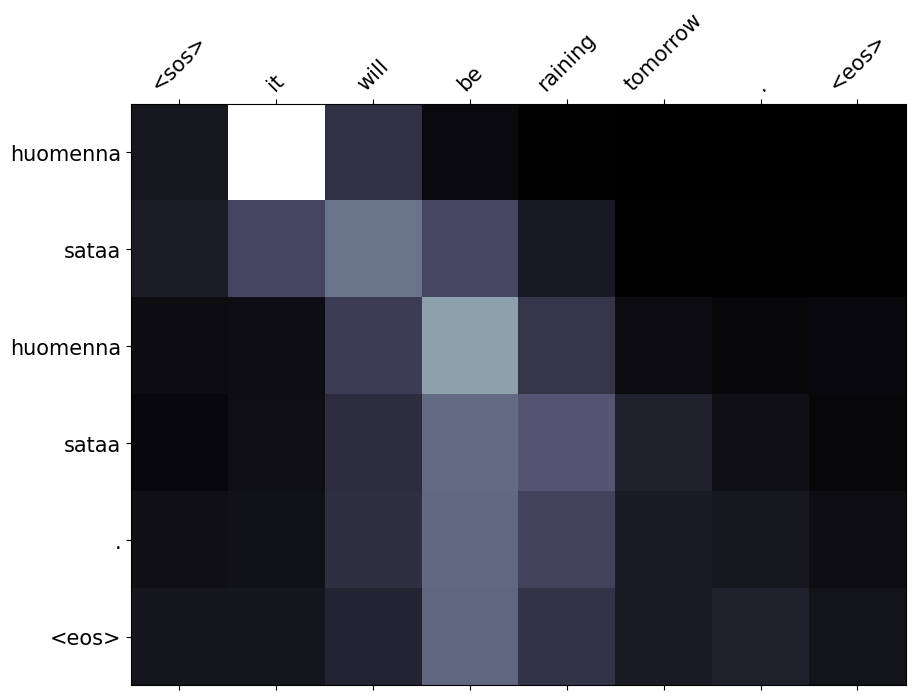

In [ ]:
# Trial3 results

translation, attention = translate_sentence(test_sen, SRC, TRG, model, device, TRG_MAX_LENGTH)

# List 형태로 반환된 translation을 string 형태로 변환
separator = ' '

predicted = separator.join(translation[:-1])  # <eos> 제외하고 이어붙임
predicted = re.sub(r" ([.!?])", r"\1", predicted) # . ! ? 앞 공백제거
predicted = predicted.capitalize()
predicted
    
print(f'Predicted sentence = {predicted}')
print()
print()

display_attention(test_sen, translation, attention)

Predicted sentence = Huomenna tulee huomenna.




<ipython-input-36-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-36-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


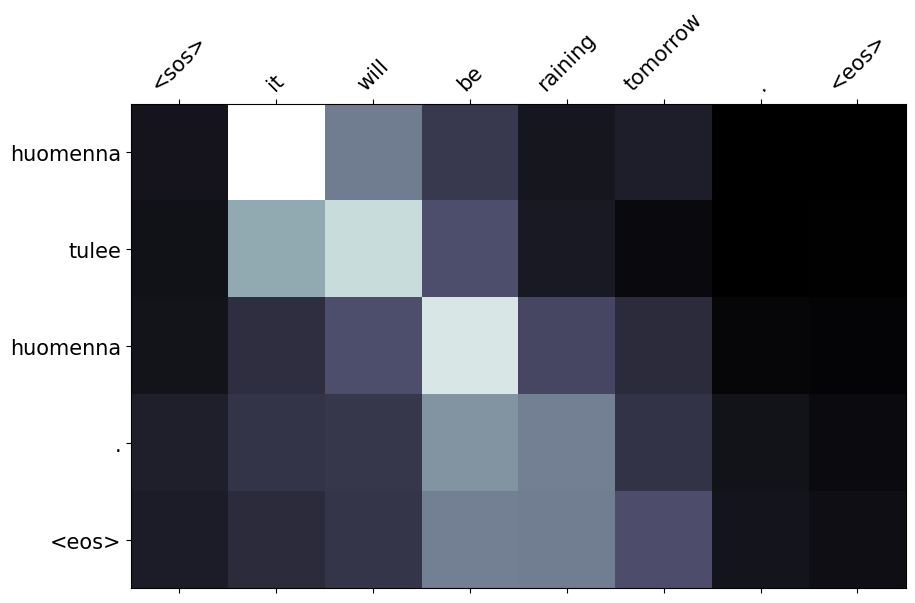

In [ ]:
# Trial5 results

translation, attention = translate_sentence(test_sen, SRC, TRG, model, device, TRG_MAX_LENGTH)

# List 형태로 반환된 translation을 string 형태로 변환
separator = ' '

predicted = separator.join(translation[:-1])  # <eos> 제외하고 이어붙임
predicted = re.sub(r" ([.!?])", r"\1", predicted) # . ! ? 앞 공백제거
predicted = predicted.capitalize()
predicted
    
print(f'Predicted sentence = {predicted}')
print()
print()

display_attention(test_sen, translation, attention)

Predicted sentence = Huomenna sataa huomenna sataa.




<ipython-input-33-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-33-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


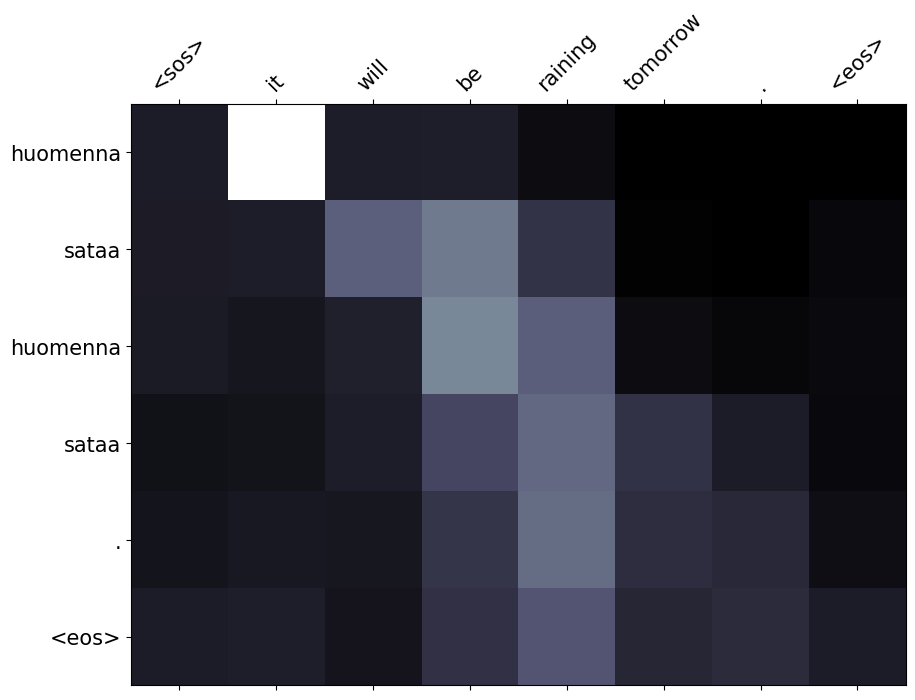

In [34]:
# Trial8 results

translation, attention = translate_sentence(test_sen, SRC, TRG, model, device, TRG_MAX_LENGTH)

# List 형태로 반환된 translation을 string 형태로 변환
separator = ' '

predicted = separator.join(translation[:-1])  # <eos> 제외하고 이어붙임
predicted = re.sub(r" ([.!?])", r"\1", predicted) # . ! ? 앞 공백제거
predicted = predicted.capitalize()
predicted
    
print(f'Predicted sentence = {predicted}')
print()
print()

display_attention(test_sen, translation, attention)

Predicted sentence = Huomenna sataa huomenna.




<ipython-input-36-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-36-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


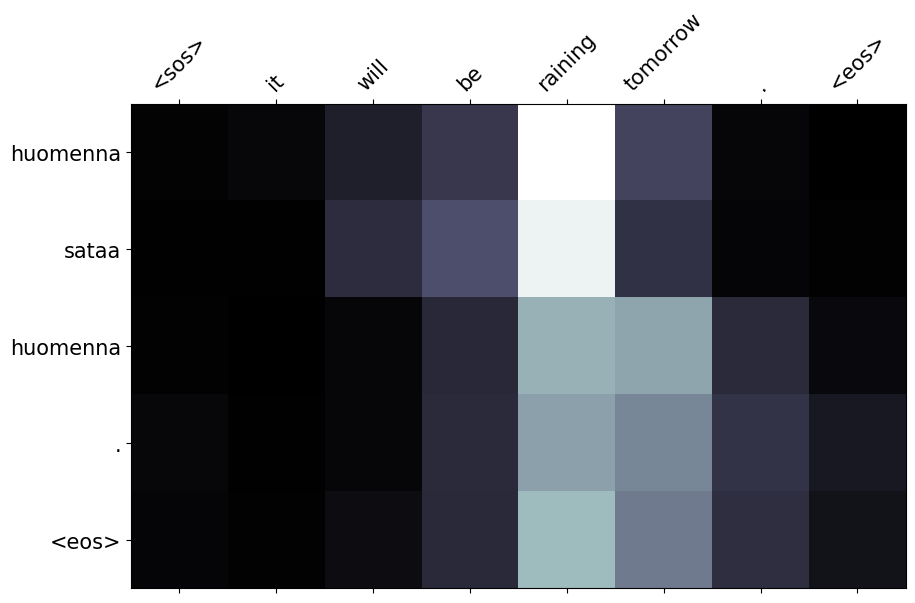

In [ ]:
# Trial9 results

translation, attention = translate_sentence(test_sen, SRC, TRG, model, device, TRG_MAX_LENGTH)

# List 형태로 반환된 translation을 string 형태로 변환
separator = ' '

predicted = separator.join(translation[:-1])  # <eos> 제외하고 이어붙임
predicted = re.sub(r" ([.!?])", r"\1", predicted) # . ! ? 앞 공백제거
predicted = predicted.capitalize()
predicted
    
print(f'Predicted sentence = {predicted}')
print()
print()

display_attention(test_sen, translation, attention)

Predicted sentence = Sade tulee.




<ipython-input-33-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-33-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


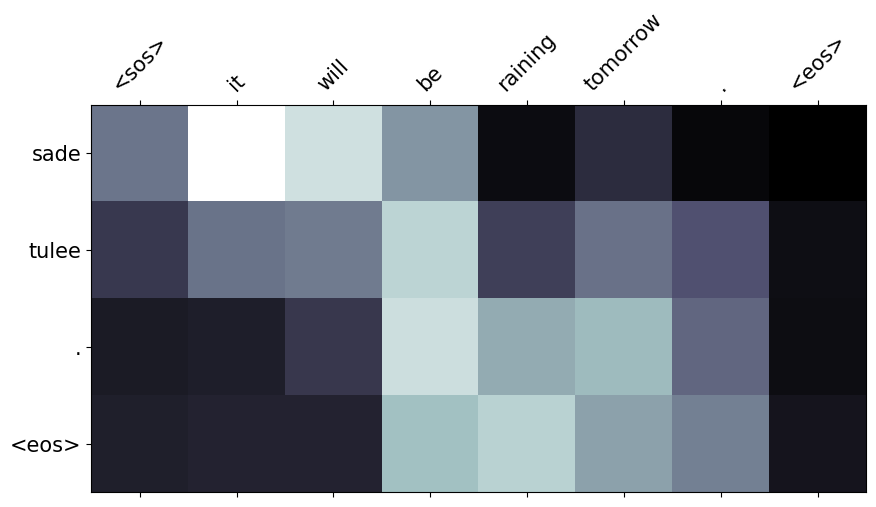

In [41]:
# Trial10 results

translation, attention = translate_sentence(test_sen, SRC, TRG, model, device, TRG_MAX_LENGTH)

# List 형태로 반환된 translation을 string 형태로 변환
separator = ' '

predicted = separator.join(translation[:-1])  # <eos> 제외하고 이어붙임
predicted = re.sub(r" ([.!?])", r"\1", predicted) # . ! ? 앞 공백제거
predicted = predicted.capitalize()
predicted
    
print(f'Predicted sentence = {predicted}')
print()
print()

display_attention(test_sen, translation, attention)

Predicted sentence = Huomenna sataa.




<ipython-input-33-98e7d903867b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-33-98e7d903867b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


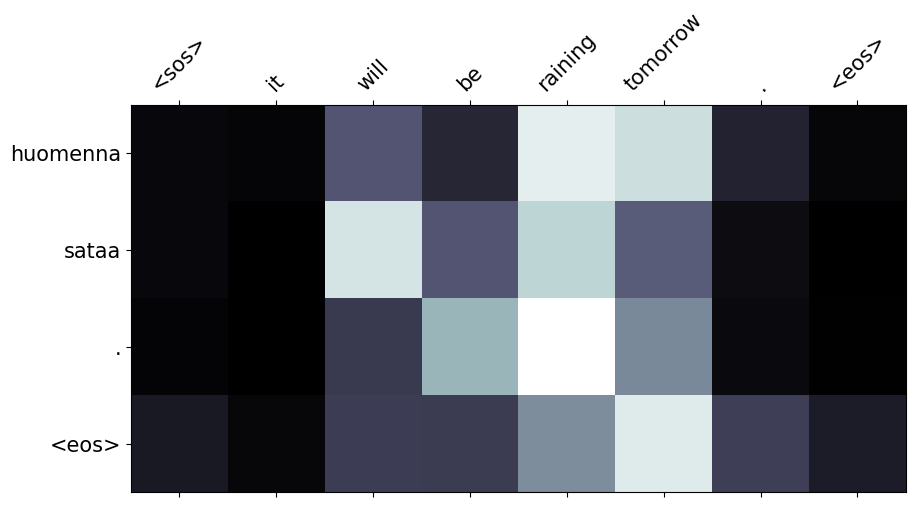

In [51]:
# Trial11 results

translation, attention = translate_sentence(test_sen, SRC, TRG, model, device, TRG_MAX_LENGTH)

# List 형태로 반환된 translation을 string 형태로 변환
separator = ' '

predicted = separator.join(translation[:-1])  # <eos> 제외하고 이어붙임
predicted = re.sub(r" ([.!?])", r"\1", predicted) # . ! ? 앞 공백제거
predicted = predicted.capitalize()
predicted
    
print(f'Predicted sentence = {predicted}')
print()
print()

display_attention(test_sen, translation, attention)

감사합니다...🥹